In [28]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from cnnlearning import *
from learningutils import *
from cell_no_cell import *
from patchextraction import *
from imageprosessing import *
from nearest_neighbors import *
from evaluation import *
from classificationutils import *
from sharedvariables import *
from vesseldetection import *
from generate_datasets import *
from guitools import CvRoipolySelector, CvPointSelector

import os
plt.rcParams['image.cmap'] = 'gray'


# Jupyter Notebook settings

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%autosave 0
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Imports for data analysis
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 2500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 2000)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# size=25
size=35
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

def get_positions_from_csv(csv_file, frame_idx):
    df = pd.read_csv(csv_file)
    all_cell_positions = df[['X', 'Y']].to_numpy().astype(np.int32)
    all_cell_frame_indices = df[['Slice']].to_numpy().astype(np.int32)
    
    return all_cell_positions[np.where(all_cell_frame_indices == frame_idx)[0]]

idx = 3
video_OA790_filename = unmarked_labeled_video_OA790_filenames[idx]
mask_video = mask_video_filenames_for_labeled_O790[idx]
csv_cords_filename   = csv_cell_cords_OA790_filenames[idx]
video_OA850_filename = unmarked_video_OA850_filenames[idx]
std_confocal_image_filename = std_confocal_images_for_labeled_OA790[idx]
std_OA850_image_filename = std_OA850_images_for_labeled_OA790[idx]
cell_positions = get_positions_from_csv(csv_cords_filename, frame_idx=1)

print('Files:')
print('------')
print(basename(video_OA790_filename), 
      basename(csv_cords_filename), 
      basename(video_OA850_filename), 
      basename(std_confocal_image_filename),
      basename(std_OA850_image_filename),
      sep='\n')

def save_stack_as_video(frames, output_name):
    _, height, width, _ = frames.shape

    fourcc = cv2.VideoWriter_fourcc('X','V','I','D')
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    out = cv2.VideoWriter(f'{output_name}', fourcc, 10.0, (width, height))

    for frame in frames:
        out.write(frame.copy())
        
    out.release()

assert files_of_same_source(video_OA790_filename, csv_cords_filename)
assert files_of_same_source(csv_cords_filename, video_OA850_filename)
assert files_of_same_source(video_OA850_filename, std_OA850_image_filename)
assert files_of_same_source(std_confocal_image_filename, std_OA850_image_filename)
mask_video_filenames_for_labeled_O790

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosave disabled
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Files:
------
Subject3_Session217_OS_(2,0)_1x1_988_OA790nm_dewarped1_extract_reg_cropped.avi
Subject3_Session217_OS_(2,0)_1x1_988_OA790nm_dewarped1_extract_reg_cropped_cords.csv
Subject3_Session217_OS_(2,0)_1x1_988_OA850nm_dewarped1_extract_reg_cropped.avi
Subject3_Session217_OS_(2,0)_1x1_988_Confocal_dewarped1_extract_reg_std.tif
Subject3_Session217_OS_(2,0)_1x1_988_OA850nm_dewarped1_extract_reg_std.tif


['',
 '',
 '.\\data\\registered-videos-2\\Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA790nm_dewarped1_extract_reg_cropped_mask.avi',
 '.\\data\\registered-videos-2\\Subject3_Session217_OS_(2,0)_1x1_988_OA790nm_dewarped1_extract_reg_cropped_mask.avi',
 '.\\data\\registered-videos-2\\Subject3_Session217_OS_(2,0)_1x1_988_OA790nm_dewarped1_extract_reg_cropped_mask.avi',
 '.\\data\\registered-videos-2\\Subject47_Session375_OD_(0,-1)_1.04x1.04_3056_OA790nm1_extract_reg_cropped_mask.avi',
 '.\\data\\registered-videos-2\\Subject48_Session379_OD_(-10,0)_1.04x1.04_3111_OA790nm1_extract_reg_cropped_mask.avi',
 '.\\data\\registered-videos-2\\Subject48_Session379_OD_(-7,-2)_1.04x1.04_3107_OA790nm1_extract_reg_cropped_mask.avi',
 '.\\data\\registered-videos-2\\Subject52_Session404_OD_(0,-3)_1.04x1.04_3466_OA790nm1_extract_reg_cropped_mask.avi',
 '.\\data\\registered-videos-2\\Subject52_Session404_OD_(0,-4)_1.04x1.04_3465_OA790nm1_extract_reg_cropped_mask.avi',
 '.\\data\\registered-videos-2\\Subjec

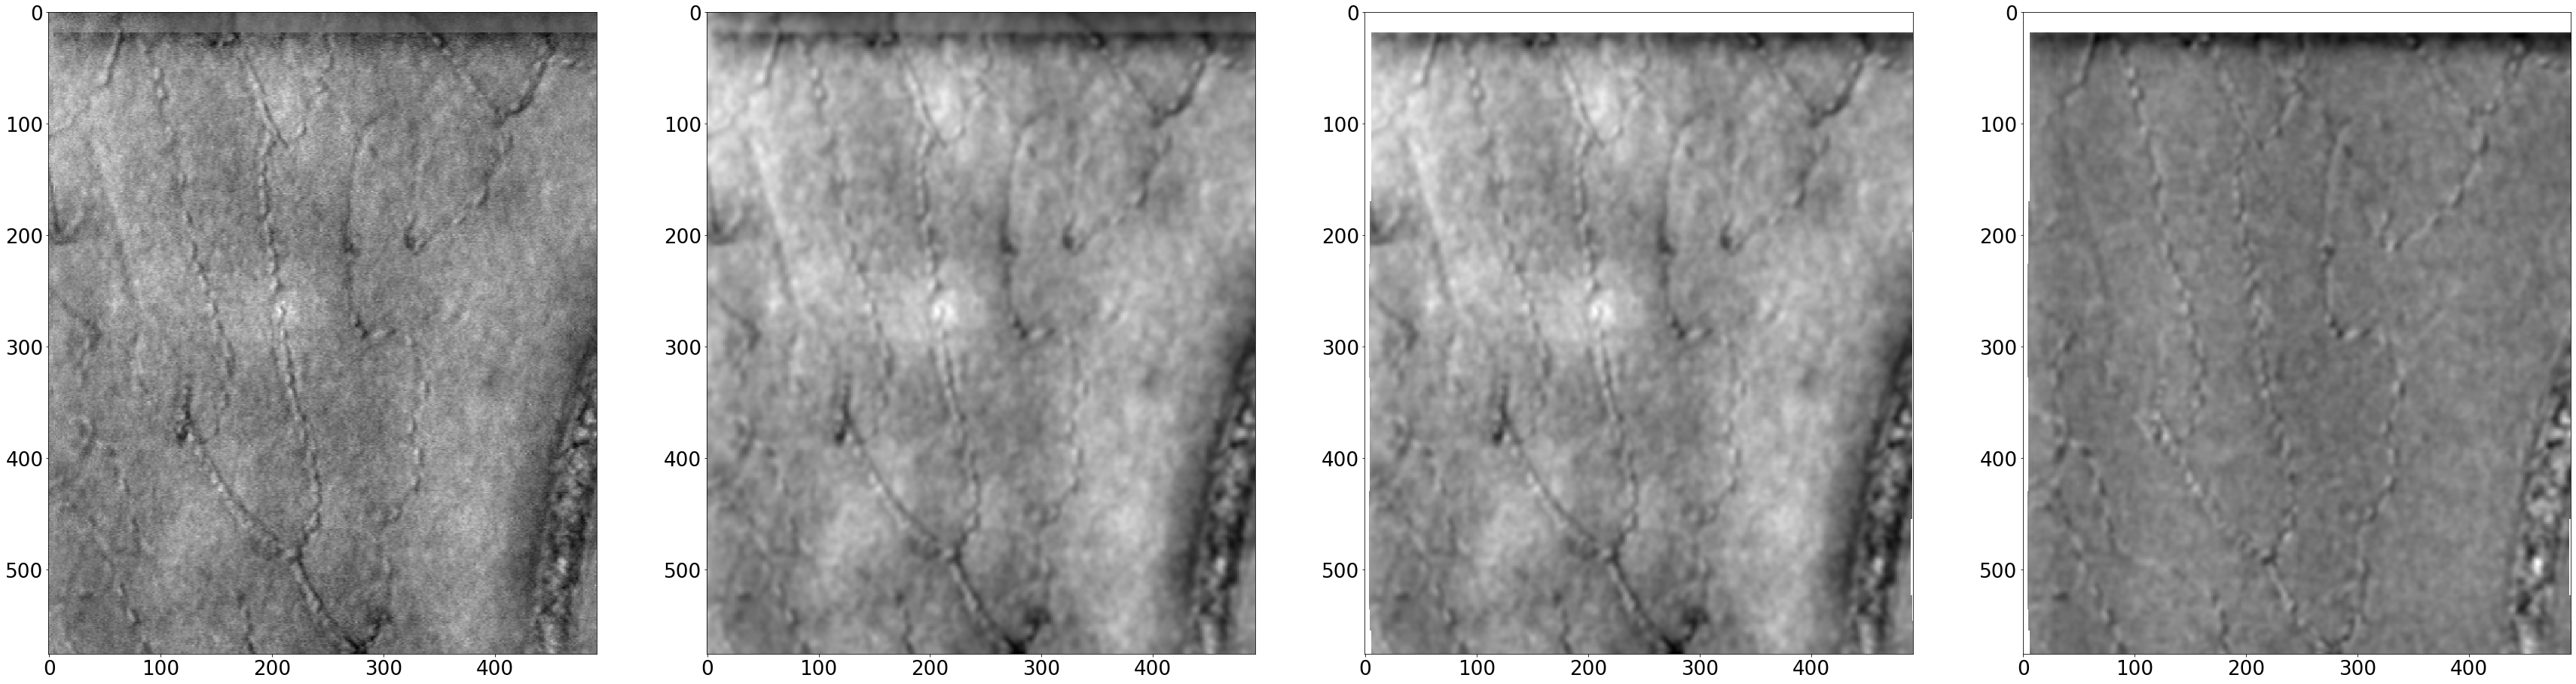

In [42]:
frames = get_frames_from_video(video_OA790_filename)[..., 0].astype(np.float64)
mask_frames = get_frames_from_video(mask_video)[..., 0].astype(np.bool8)

fig, axes = plt.subplots(1, 4, figsize=(60, 60))

sigma = 2
axes[0].imshow(frames[0, ...])

for i, frame in enumerate(frames):
    frames[i, ...] = mh.gaussian_filter(frame, sigma)
axes[1].imshow(frames[0, ...])

# We invert the mask because True values mean that the values are masked and therefor invalid
# https://numpy.org/doc/stable/reference/maskedarray.generic.html
masked_frames = np.ma.masked_array(frames, ~mask_frames)
for i, masked_frame in enumerate(masked_frames):
    masked_frames[i, ...] = masked_frame / np.ma.mean(masked_frame)
axes[2].imshow(masked_frames[0, ...])
  
m = np.ma.mean(masked_frames, axis=0)
for i, masked_frame in enumerate(masked_frames):
    masked_frames[i, ...] = masked_frame / m
axes[3].imshow(masked_frames[0, ...])

In [43]:
res = masked_frames.filled(masked_frames.mean())
res = normalize_data(res, 0, 255).astype(np.uint8)

res_color = np.zeros_like(res, shape=(*res.shape, 3))
res_color[..., 0] = res
res_color[..., 1] = res
res_color[..., 2] = res
res_color.shape

save_stack_as_video(res_color, f'{os.path.splitext(basename(video_OA790_filename))[0]}_{sigma}_normalised.avi')


In [45]:
frames = get_frames_from_video(video_OA790_filename)
save_stack_as_video(res_color, f'{os.path.splitext(basename(video_OA790_filename))[0]}_original.avi')